In [50]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# INITIALIZATION 

# Input time T, and number of timesteps N, output initial vectors
def initialize(T, N):
    # Position
    r_range = np.zeros((N, 3))
    # Velocity
    v_range = np.zeros((N, 3))
    # Euler Angles
    angle_range = np.zeros((N, 3))
    # Angular Velocity
    omega_range = np.zeros((N, 3))
    # Time
    t_range = np.linspace(0, T, N+1)[:-1]
    # State Vector
    x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])
    return r_range, v_range, angle_range, omega_range, t_range, x

In [52]:
# TRANSLATIONAL DYNAMICS

# Input Euler angles (phi, theta, psi) and output rotation matrix
def calc_rotation_matrix(angles):
    phi, theta, psi = angles
    R = np.array([[np.cos(phi)*np.cos(theta),
                   np.cos(phi)*np.sin(theta)*np.sin(phi) - np.sin(psi)*np.cos(phi),
                   np.cos(psi)*np.sin(theta)*np.cos(phi) + np.sin(psi)*np.sin(phi)],     
                  [np.sin(psi)*np.cos(theta),
                   np.sin(psi)*np.sin(theta)*np.sin(phi) + np.cos(psi)*np.cos(phi),
                   np.sin(psi)*np.sin(theta)*np.cos(phi)-np.cos(psi)*np.sin(phi)],
                  [-np.sin(theta),
                   np.cos(theta)*np.sin(phi),
                   np.cos(theta)*np.cos(phi)]])
    return R

# Input speeds of the rotors (omega 1, 2, 3, 4) and output thrust
def calc_thrust(k, rotor_speeds):
    omega1, omega2, omega3, omega4 = rotor_speeds
    T = k * (omega1**2 + omega2**2 + omega3**2 + omega4**2)
    T_vect = np.array([0, 0, T])
    return T_vect

# Input constants, m, g, and T and R to output linear acceleration 
def calc_linear_acceleration(m, g, angles, dir, k, rotor_speeds):
    R = calc_rotation_matrix(angles)
    T = calc_thrust(k, rotor_speeds)
    R_dir = np.array([[dir[0], -dir[1], 0],
                            [dir[1], dir[0], 0],
                            [0, 0, 1]])
    G = np.array([0, 0, m*g])
    linear_acceleration = (1/m)* (G + R_dir @ R.T @ T)
    if np.abs(linear_acceleration[2]) < 1e-6:
        linear_acceleration[2] = 0
    return linear_acceleration


In [53]:
# ROTATIONAL DYNAMICS

# Input constants l, k, b, rotor speeds (omega 1,2,3,4), output the torque vector
def calc_torque(l, k, b, rotor_speeds):
    omega1, omega2, omega3, omega4 = rotor_speeds
    tau_phi = l*k*(omega4**2 - omega2**2)
    tau_theta = l*k*(omega3**2 - omega1**2)
    tau_psi = b*(omega1**2 - omega2**2 + omega3**2 - omega4**2)
    tau = np.array([tau_phi, tau_theta, tau_psi])
    return tau

# Input I values, omega (p, q, r), constants, and rotor speeds, Output the rotational acceleration wrt body frame
def calc_rotational_acceleration(I_values, omega, l, k, b, rotor_speeds):
    tau = calc_torque(l, k, b, rotor_speeds)
    Ixx, Iyy, Izz = I_values
    I = np.diag([Ixx, Iyy, Izz])
    nu_dot = I @ (tau - np.cross(omega,(I @ omega)))
    return nu_dot

 


In [54]:
# PROPOGATION OVER TIME

def f(x, args):
    m, g, k, dir, rotor_speeds, I_values, l, b = args
    # Splitting up the state vector
    r = x[0:3]
    v = x[3:6]
    angle = x[6:9]
    omega = x[9:12]
    # Calculate acceleration
    a = calc_linear_acceleration( m, g, angle, dir, k, rotor_speeds)
    # Calculate angular acceleration
    alpha = calc_rotational_acceleration(I_values, omega, l, k, b, rotor_speeds)
    xdot = np.concatenate([v, a, omega, alpha])
    return xdot

def RK4(x, dt, args):
    k1 = f(x, args)
    k2 = f(x + dt * k1 / 2, args)
    k3 = f(x + dt * k2 / 2, args)
    k4 = f(x + dt * k3, args)
    x_posteriori = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_posteriori


In [66]:
# PLOTS

# Plot results
def plot_results(r_range, v_range, angle_range, omega_range, t_range):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.15)

    # Function to add more ticks manually
    def set_more_ticks(ax, x_data, y_data):
        ax.set_xticks(np.linspace(min(x_data), max(x_data), 12))
        ax.set_yticks(np.linspace(min(y_data), max(y_data), 12))

    # Plot Position (r_range)
    ax[0, 0].plot(t_range, r_range[:, 0], label=r"x", color='b')
    ax[0, 0].plot(t_range, r_range[:, 1], label=r"y", color='g')
    ax[0, 0].plot(t_range, r_range[:, 2], label=r"z", color='r')
    ax[0, 0].set_xlabel("Time (s)")
    ax[0, 0].set_ylabel("Position (m)")
    ax[0, 0].set_title("Position vs Time")
    ax[0, 0].legend()
    set_more_ticks(ax[0, 0], t_range, r_range.flatten())

    # Plot Velocity (v_range)
    ax[0, 1].plot(t_range, v_range[:, 0], label=r"$V_x$", color='b')
    ax[0, 1].plot(t_range, v_range[:, 1], label=r"$V_y$", color='g')
    ax[0, 1].plot(t_range, v_range[:, 2], label=r"$V_z$", color='r')
    ax[0, 1].set_xlabel("Time (s)")
    ax[0, 1].set_ylabel("Velocity (m/s)")
    ax[0, 1].set_title("Velocity vs Time")
    ax[0, 1].legend()
    set_more_ticks(ax[0, 1], t_range, v_range.flatten())

    # Plot Euler Angles (angle_range)
    ax[1, 0].plot(t_range, angle_range[:, 0], label=r"$\phi$", color='b')
    ax[1, 0].plot(t_range, angle_range[:, 1], label=r"$\theta$", color='g')
    ax[1, 0].plot(t_range, angle_range[:, 2], label=r"$\psi$", color='r')
    ax[1, 0].set_xlabel("Time (s)")
    ax[1, 0].set_ylabel("Angle (rad)")
    ax[1, 0].set_title("Euler Angles vs Time")
    ax[1, 0].legend()
    set_more_ticks(ax[1, 0], t_range, angle_range.flatten())

    # Plot Angular Velocity (omega_range)
    ax[1, 1].plot(t_range, omega_range[:, 0], label=r"$p$", color='b')
    ax[1, 1].plot(t_range, omega_range[:, 1], label=r"$q$", color='g')
    ax[1, 1].plot(t_range, omega_range[:, 2], label=r"$r$", color='r')
    ax[1, 1].set_xlabel("Time (s)")
    ax[1, 1].set_ylabel("Angular Velocity (rad/s)")
    ax[1, 1].set_title("Angular Velocity vs Time")
    ax[1, 1].legend()
    set_more_ticks(ax[1, 1], t_range, omega_range.flatten())

    plt.show()


# Plot 2D position
def plot_position_2D(r_range):
    plt.plot(r_range[:, 0], r_range[:, 1], label="Trajectory")
    plt.scatter(r_range[0, 0], r_range[0, 1], color='r', s=50, label='Starting Point')
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.text(r_range[0, 0] + 0.1, r_range[0, 1] + 0.1, 'Start', color='r')
    plt.legend()
    plt.axis('equal')
    plt.title('2D Drone Position')
    plt.show()

# # Plot 3D position
def plot_position_3D_hover(r_range, y_offset = -0.02):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r_range[:,0], r_range[:,1], r_range[:,2], linewidth=2, color='b', label='Trajectory')
    y_ticks = ax.get_yticks()
    y_ticks_offset = y_ticks + y_offset
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{val:.2f}" for val in y_ticks_offset])
    start_point = r_range[0]
    final_point = r_range[-1]
    ax.scatter(start_point[0], start_point[1], start_point[2], color='r', s=10, label='Start Point')
    ax.scatter(final_point[0], final_point[1], final_point[2], color='g', s=10, label='Final Point')
    ax.set_zlim(0, 2)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    ax.set_title("3D Drone Position")
    plt.legend()
    plt.show()


# Plot 3D position
def plot_position_3D_circle(r_range):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r_range[:,0], r_range[:,1], r_range[:,2], linewidth=2, color='b', label='Trajectory')
    start_point = r_range[0]
    final_point = r_range[-1]
    ax.scatter(start_point[0], start_point[1], start_point[2], color='r', s=10, label='Start Point')
    ax.scatter(final_point[0], final_point[1], final_point[2], color='g', s=10, label='Final Point')
    ax.set_zlim(0, 2)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    ax.set_title("3D Drone Position")
    plt.legend()
    plt.show()

# Plot 3D position - for BONUS
def plot_position_3D_bonus(r_range):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r_range[:,0], r_range[:,1], r_range[:,2], linewidth=2, color='b', label='Trajectory')
    start_point = r_range[0]
    final_point = r_range[-1]
    ax.scatter(start_point[0], start_point[1], start_point[2], color='r', s=10, label='Start Point')
    ax.scatter(final_point[0], final_point[1], final_point[2], color='g', s=10, label='Final Point')
    ax.set_zlim(0, 1.5)
    ax.set_ylim(-1.0, 5.5)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    ax.set_title("3D Drone Position")
    plt.legend()
    plt.show()

In [56]:
# CONSTANTS

m = 0.225 # mass in kg
g = -9.8 # acceleration due to gravity m/s**2
k = 1.5e-5 # thrust coefficient
b = 1.32e-7 # torque coeffiecient
l = 0.15 # rotor arm length in m

# Moment of inertia
Ixx = 0.001 # rotational inertia about the x axis 
Iyy = 0.001 # rotational inertia about the y axis 
Izz = 0.002 # rotational inertia about the z axis 

I_values = np.array([Ixx, Iyy, Izz]) # rotational inertia matrix

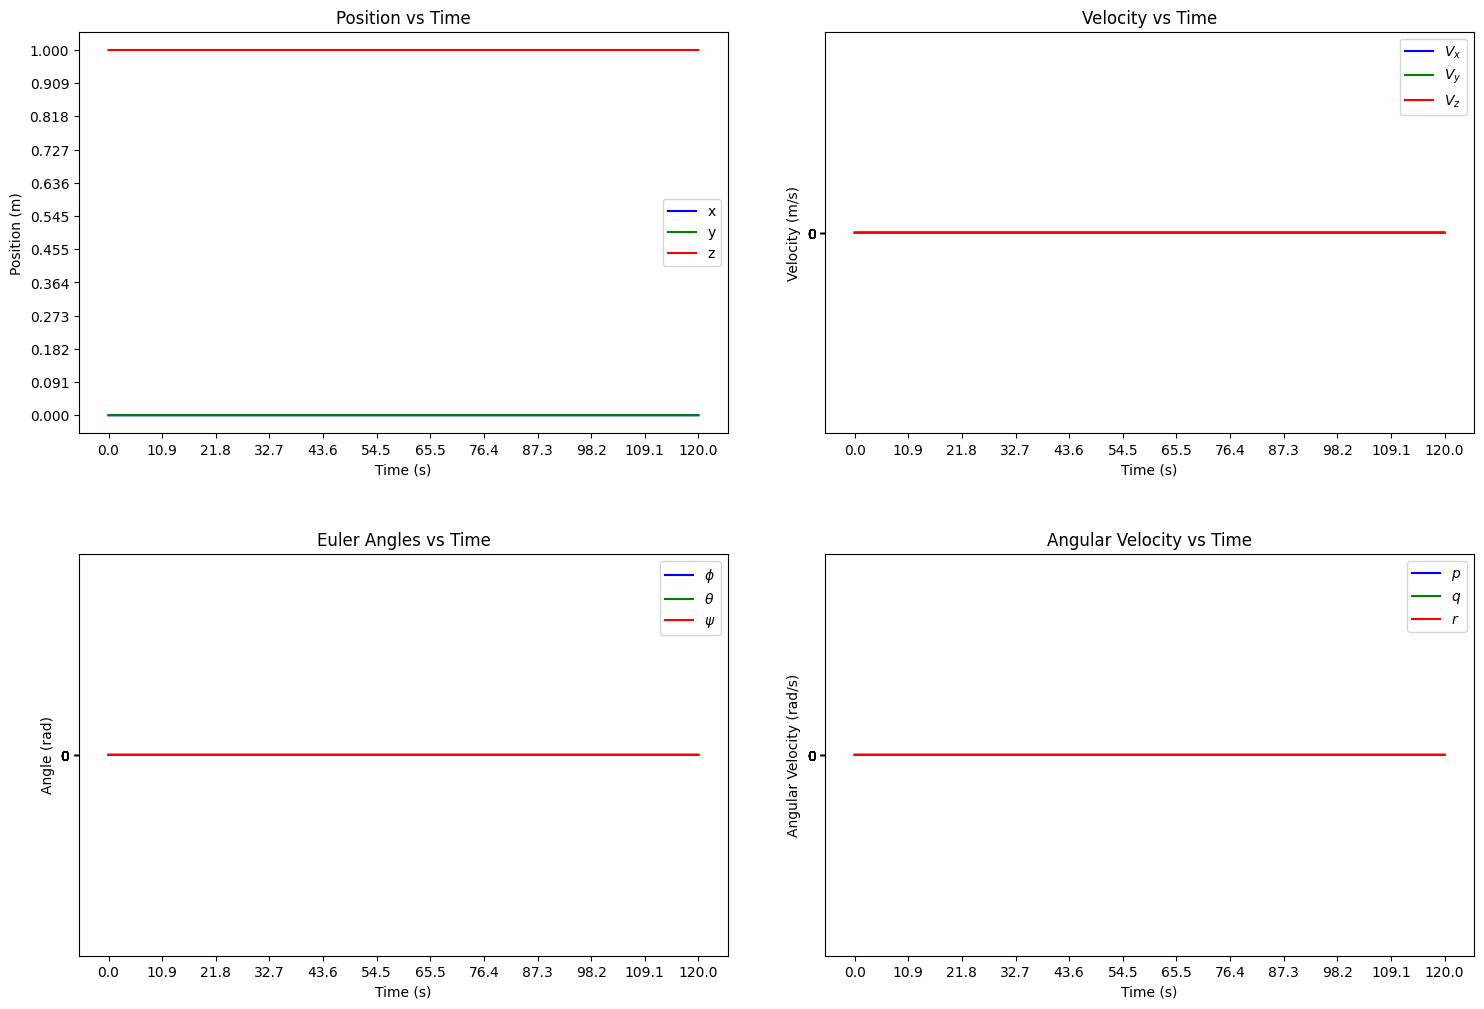

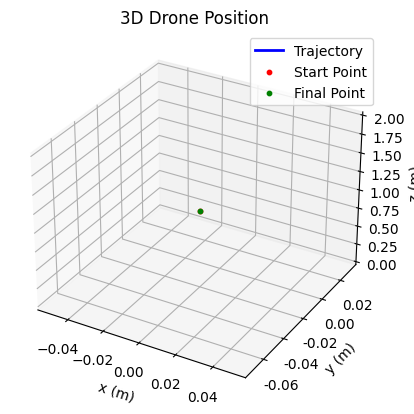

In [67]:
# HOVER

# Time
dt = 0.001 # time step in s
T = 120 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Conditions for hovering 1m above the ground
# Hovering position
r_range[0] = np.array([0, 0, 1])
x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

# Calculating Rotor Speeds from Thrust
thrust = -m*g
mag_speed = np.sqrt((thrust/(4*k)))
rotor_speed = np.array([mag_speed, -mag_speed, mag_speed, -mag_speed])

# Direction of velocity - along z axis
dir = np.array([0, 0, 1])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-6:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori


# Plot results
plot_results(r_range, v_range, angle_range, omega_range, t_range)
plot_position_3D_hover(r_range)

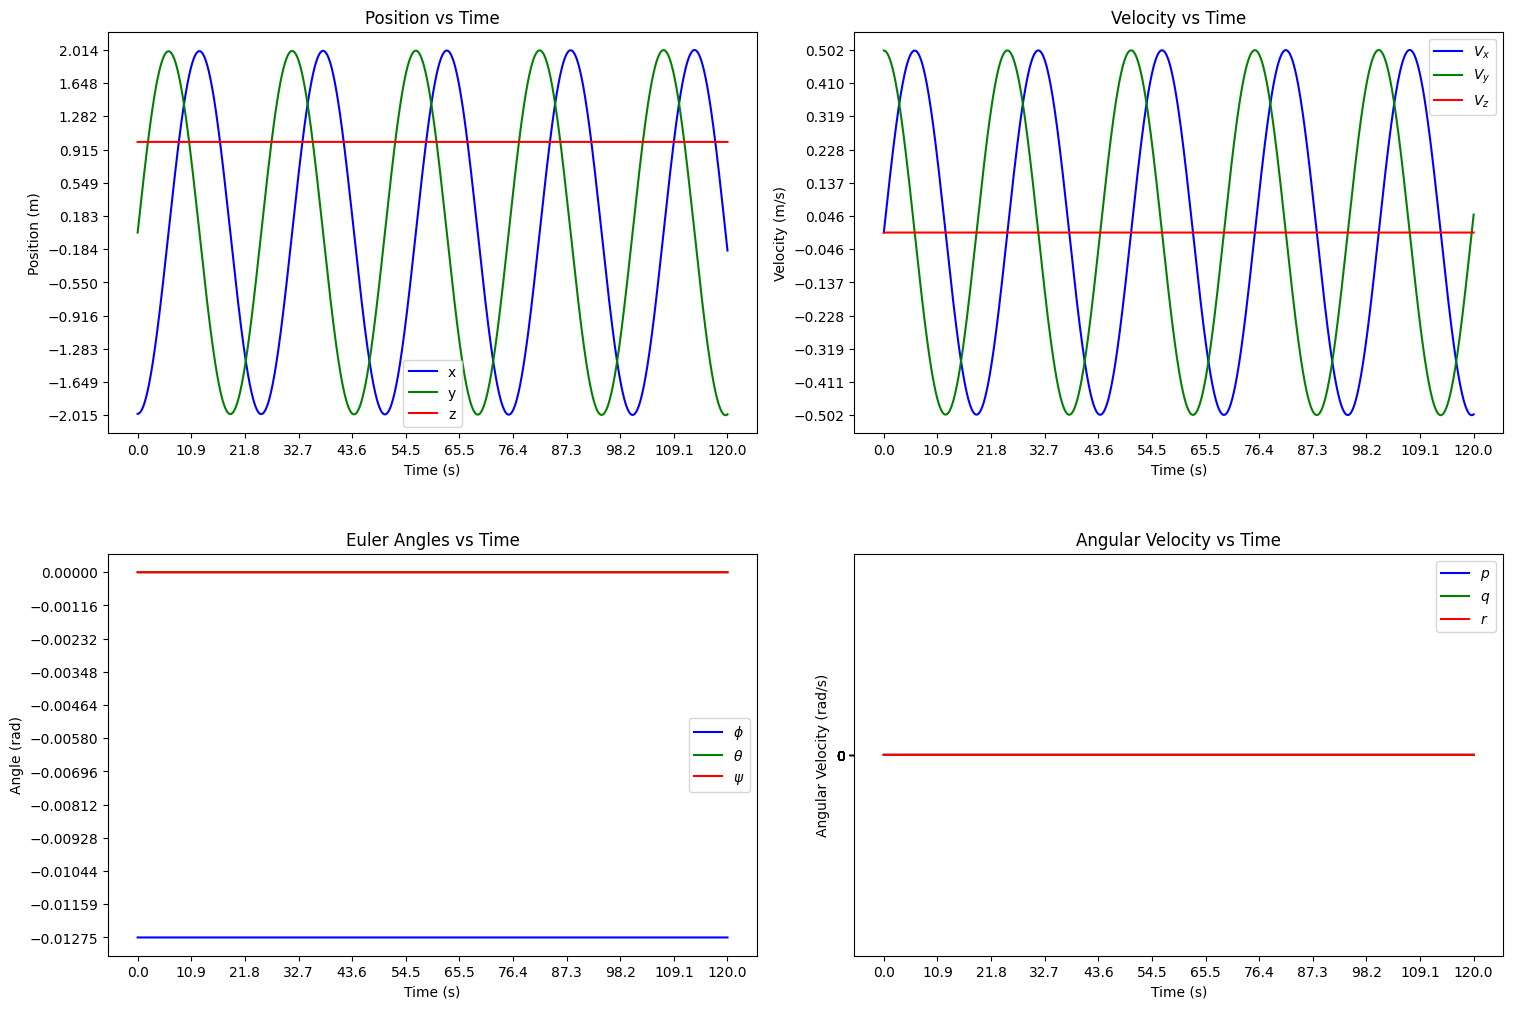

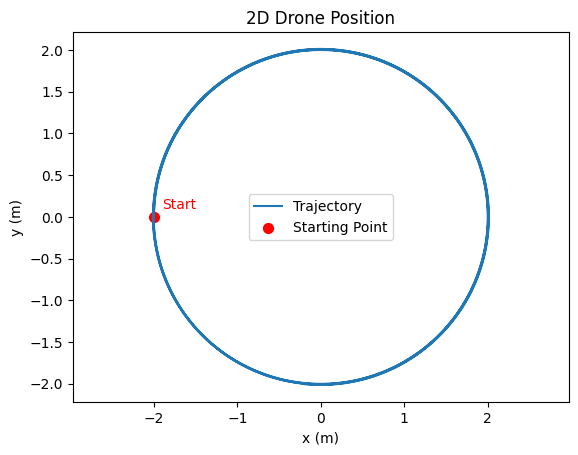

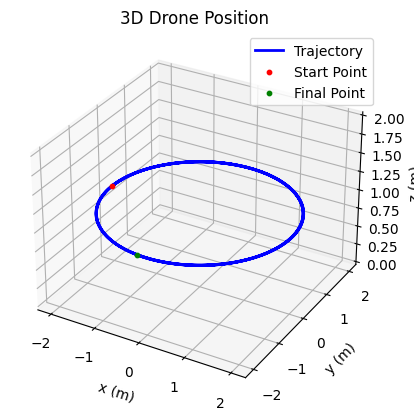

In [68]:
# CIRCLE

# Time
dt = 0.001 # time step in s
T = 120 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Conditions for circle
circle_radius = 2 # m
altitude = 1 # m
quadrotor_speed = 0.5 # m/s

# Iniital position and velocity
r_range[0] = np.array([-circle_radius, 0, altitude])
v_range[0] = np.array([0, quadrotor_speed, 0]) # tangential velocity

# Accelerations
a_c = -(quadrotor_speed ** 2) / circle_radius # Centripetal acceleration due to circular motion
a_g = -g # acceleration to counter act gravity
phi = np.arctan2(a_c,a_g) # Euler angle
angle_range[0] = np.array([phi, 0, 0])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_c ** 2 + a_g ** 2)
mag_speed = np.sqrt((thrust/(4*k)))
rotor_speed = np.array([mag_speed, -mag_speed, mag_speed, -mag_speed])

# Direction of velocity
dir = v_range[0]/np.linalg.norm(v_range[0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, quadrotor_speed, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori


# Plot results
plot_results(r_range, v_range, angle_range, omega_range, t_range)
plot_position_2D(r_range)
plot_position_3D_circle(r_range)

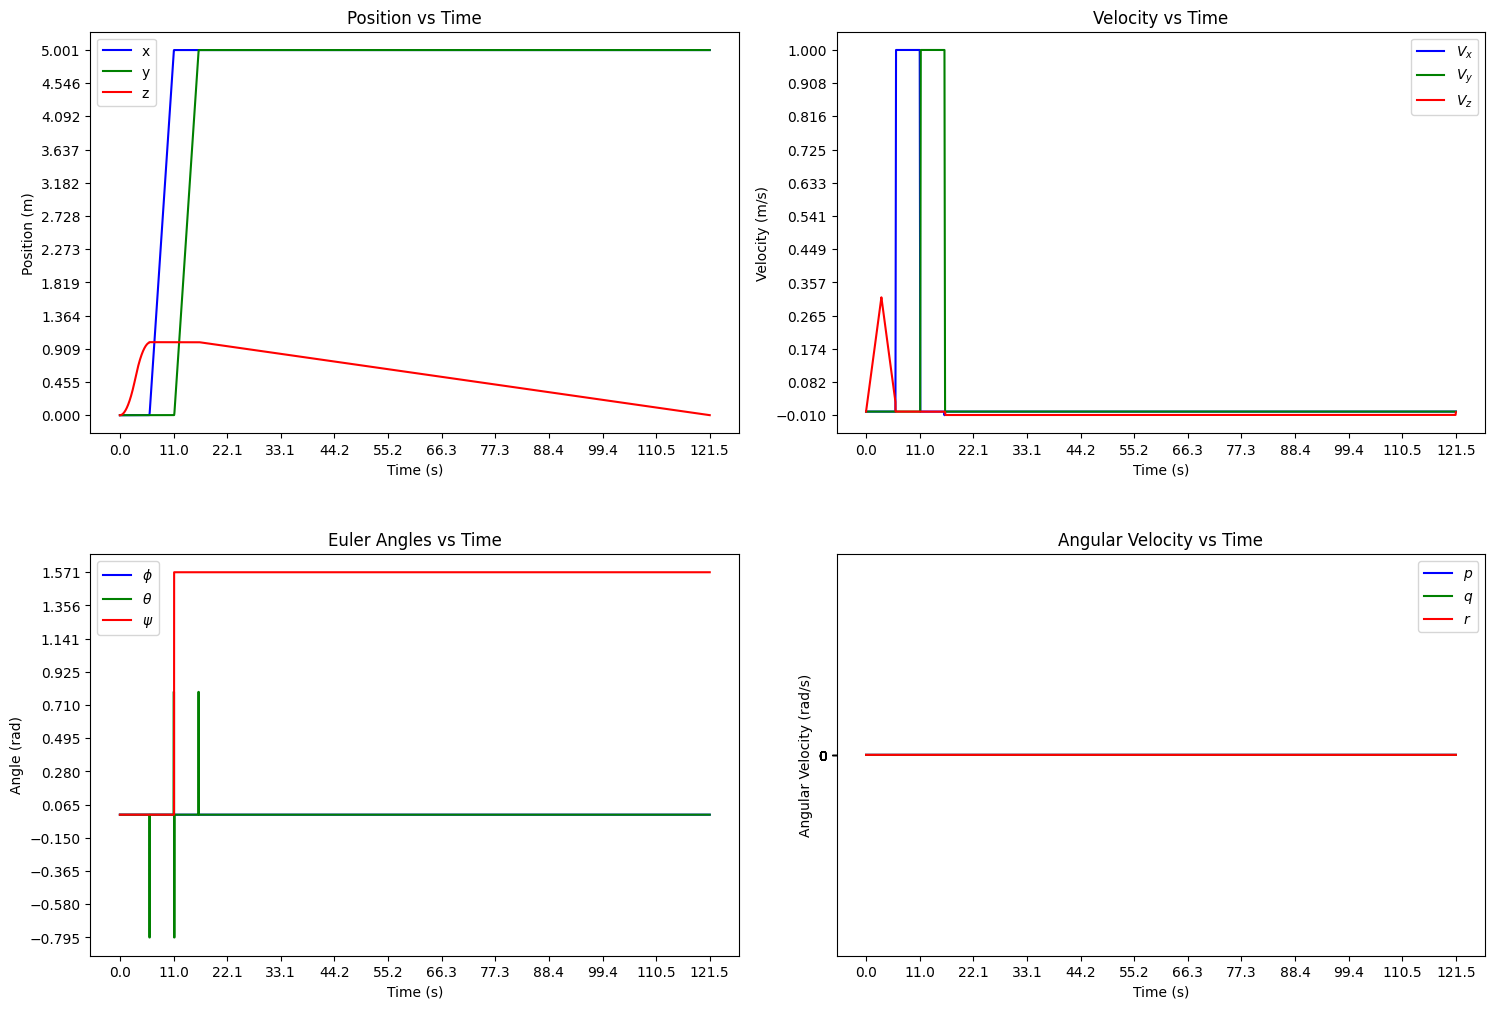

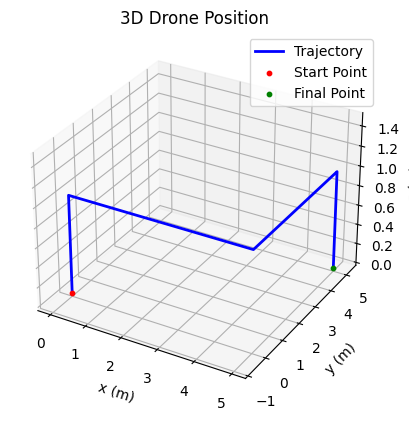

In [ ]:
# BONUS

r_range_total = np.empty((0, 3))
v_range_total = np.empty((0, 3))
angle_range_total = np.empty((0, 3))
omega_range_total = np.empty((0, 3))
t_range_total = np.array([])

# Function to Calculate Rotor Speeds from Thrust
def calc_rotor_speed(thrust):
    mag_speed = np.sqrt((thrust/(4*k)))
    rotor_speed = np.array([mag_speed, -mag_speed, mag_speed, -mag_speed])
    return rotor_speed

# ASCENDING------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = np.array([0, 0, 0])
v_range[0] = np.array([0, 0, 0]) # tangential velocity

# Accelerations
a_g = -g # Counteract gravity

# Calculating Rotor speeds using thrust
thrust = m * (a_g + 0.1)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 0, 1])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if (altitude/2 - 0.001 <= r_range[t][2] <= altitude/2 + 0.005): # Approximate. Error would be corrected if a controller is present
        thrust = m * (a_g - 0.1)
        rotor_speed = calc_rotor_speed(thrust)
    elif (altitude - 0.005 <= r_range[t][2] <= altitude + 0.005): # Approximate. Error would be corrected if a controller is present
        thrust = m * (a_g)
        rotor_speed =  calc_rotor_speed(thrust)
        if (v_range[t][2] < 0.03): # Approximate. Error would be corrected if a controller is present
            end_time = t
            break

# Store Data for Plotting
t_final = np.linspace(0.0, end_time * dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# ACCELERATION IN X DIRECTION------------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = np.array([0, 0, 1])
v_range[0] = np.array([0, 0, 0])

# Accelerations
a_g = -g # Counteract gravity
a_f = 10 # Forward Acceleration
theta = - np.arctan2(a_f,a_g) # Euler angle
angle_range[0] = np.array([0, theta, 0])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_f ** 2 + a_g ** 2)

rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([1, 0, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([1, 0, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if (1 - 0.0001 <= v_range[t][0] <= 1 + 0.05): # Approximate. Error would be corrected if a controller is present
        end_time = t
        acc_dist = r_range[t]
        acc_vel = v_range[t]
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# CONSTANT VELOCITY IN X DIRECTION---------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = acc_dist
v_range[0] = acc_vel

# Accelerations
a_g = -g # Counteract gravity
angle_range[0] = np.array([0, 0, 0])

# Calculating Rotor speeds using thrust
thrust = m * a_g
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([1, 0, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([1, 0, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if ((5 - acc_dist[0]) - 0.0001 <= r_range[t][0]<= (5 - acc_dist[0]) + 0.005): # Approximate. Error would be corrected if a controller is present
        end_time = t
        const_dist = r_range[t]
        const_vel = v_range[t]
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# DECELERATION IN X DIRECTION------------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = const_dist
v_range[0] = const_vel

# Accelerations
a_g = -g # Counteract gravity
a_f = -10 # Forward Acceleration
theta = - np.arctan2(a_f,a_g) # Euler angle
angle_range[0] = np.array([0, theta, 0])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_f ** 2 + a_g ** 2)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([1, 0, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([1, 0, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if (-0.04 <= v_range[t][0] <= 0.04): # Approximate. Error would be corrected if a controller is present
        end_time = t
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))


# ACCELERATION IN Y DIRECTION--------------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = np.array([5, 0, 1])
v_range[0] = np.array([0, 0, 0])

# Accelerations
a_g = -g # Counteract gravity
a_f = 10 # Forward Acceleration
theta = - np.arctan2(a_f,a_g) # Euler angle
psi = np.pi/2# Euler angle
angle_range[0] = np.array([0, theta, psi])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_f ** 2 + a_g ** 2)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 1, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 1, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if (1 - 0.001 <= v_range[t][1] <= 1 + 0.05): # Approximate. Error would be corrected if a controller is present
        end_time = t
        acc_dist = r_range[t]
        acc_vel = v_range[t]
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# CONSTANT SPEED IN Y DIRECTION (1 m/s)-------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = acc_dist
v_range[0] = acc_vel

# Accelerations
a_g = -g # Counteract gravity
psi = np.pi/2# Euler angle
angle_range[0] = np.array([0, 0, psi])

# Calculating Rotor speeds using thrust
thrust = m * a_g
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 1, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 1, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if ((5 - acc_dist[1]) - 0.001 <= r_range[t][1]<= (5 - acc_dist[1]) + 0.005): # Approximate. Error would be corrected if a controller is present
        end_time = t
        const_dist = r_range[t]
        const_vel = v_range[t]
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# DECELERATION IN Y DIRECTION----------------------------------------------------------------------------------------------------------------------------------------------------------

# # Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = const_dist
v_range[0] = const_vel

# Accelerations
a_g = -g # Counteract gravity
a_f = - 10 # Forward Acceleration
theta = - np.arctan2(a_f,a_g) # Euler angle
psi = np.pi/2
angle_range[0] = np.array([0, theta, psi])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_f ** 2 + a_g ** 2)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([1, 0, 0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([1, 0, 0])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if (-0.04 <= v_range[t][1] <= 0.04): # Approximate. Error would be corrected if a controller is present
        end_time = t
        break

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))


# DESCENDING WITH DOWNWARD ACCELERATION------------------------------------------------------------------------------------------------------------------------------------------------------

# Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = np.array([5, 5, 1])
v_range[0] = np.array([0, 0, 0])
psi = np.pi/2# Euler angle
angle_range[0] = np.array([0, 0, psi])

# Accelerations
a_g = -g # Counteract gravity

# Calculating Rotor speeds using thrust
thrust = m * (a_g - 0.1)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 0, 1])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori
    # Conditions
    if (-0.0095 >= v_range[t][2] >= -0.01): # Approximate. Error would be corrected if a controller is present
        end_time = t
        acc_dist = r_range[t]
        acc_vel = v_range[t]
        break
    

# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# DESCENDING WITH CONSTANT VELOCITY------------------------------------------------------------------------------------------------------------------------------------------------------

# Time
dt = 0.001 # time step in s
T = 200 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = acc_dist
v_range[0] = acc_vel
psi = np.pi/2 # Euler angle
angle_range[0] = np.array([0, 0, psi])

# Accelerations
a_g = -g # Counteract gravity

# Calculating Rotor speeds using thrust
thrust = m * a_g
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 0, 1])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori

    # Conditions
    if ((1 - acc_dist[2]) - 0.0001 <= r_range[t][2]<= (1 - acc_dist[2]) + 0.0005): # Approximate. Error would be corrected if a controller is present
        end_time = t
        const_dist_alt = r_range[t]
        const_vel_alt = v_range[t]
        break


# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# DESCENDING WITH UPWARD ACCELERATION-------------------------------------------------------------------------------------------------------------------------------------------------

# Time
dt = 0.001 # time step in s
T = 100 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Iniital position and velocity
r_range[0] = const_dist_alt
v_range[0] = const_vel_alt
psi = np.pi/2 # Euler angle
angle_range[0] = np.array([0, 0, psi])

# Accelerations
a_g = -g # Counteract gravity

# Calculating Rotor speeds using thrust
thrust = m * (a_g + 0.1)
rotor_speed = calc_rotor_speed(thrust)

# Direction of velocity
dir = np.array([0, 0, 1])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]

    # Updating direction of velocity
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction

    # Updating state vector with posteriori value
    x = x_posteriori
    # Conditions
    if (-0.002 <= v_range[t][2] <= 0.0002): # Approximate. Error would be corrected if a controller is present
        end_time = t
        break


# Store Data for Plotting
t_final = np.linspace(t_final[-1] + dt, t_final[-1] + (end_time) * dt + dt, end_time)
t_range_total = np.concatenate((t_range_total, t_final))
r_range_total = np.concatenate((r_range_total, r_range[:len(t_final)]))
v_range_total = np.concatenate((v_range_total, v_range[:len(t_final)]))
angle_range_total = np.concatenate((angle_range_total, angle_range[:len(t_final)]))
omega_range_total = np.concatenate((omega_range_total, omega_range[:len(t_final)]))

# Plot results
plot_results(r_range_total, v_range_total, angle_range_total, omega_range_total, t_range_total)
plot_position_3D_bonus(r_range_total)
